# Expectation-maximization algorithm

## Introduction

In this exercise you will segment three tissue classes in an MR image based on a generative model which you will fit to the image data. You will perform the Expectation-Maximization algorithm to fit the model parameters.
The MR data for this exercise consists of a 2-dimensional slice of a brain scan in the axial
orientation. The file _segmentData.mat_ contains the original slice as well as a mask that excludes
non-brain tissues such as eyeballs, fat, skin, etc. The file _correctedData.mat_ contains the same
image, but after it has been corrected for the MR bias field artifact using the method described in
section 3.5. It is this image you will be modeling.

### Instructions for your report
Your report should be structured as follows:
* **Introduction**: a short summary of what your report is about, perhaps with a recap of some of the equations you'll be using in your solution.
* **Task 1, ..., 5**: for each specific task listed below, your code (in code cells), your results (as figures) as well as explanations of what is computed and what is shown in the figures (in Markdown cells). 
* **Conclusion**: a short summary of your findings.

This introduction should **not** be part of your report.

### Input data and code hints
Import Python libraries:

In [3]:
import numpy as np
import scipy
from scipy.io import loadmat
from scipy import signal
import warnings
warnings.filterwarnings("ignore")
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.mlab as mlab
%matplotlib inline

## Task 1: Image data
Display the image provided in "correctedData.mat" and plot its histogram.

> ***Hints:***
> - .mat data can be loaded in python as follows
>   
>       mat = loadmat("correctedData.mat")
> 
>       data = mat["correctedData"]
>
> - Use 100 bins for your histogram
> - The mask sets all background pixels to zero. Disregard the background pixels by clipping 0.

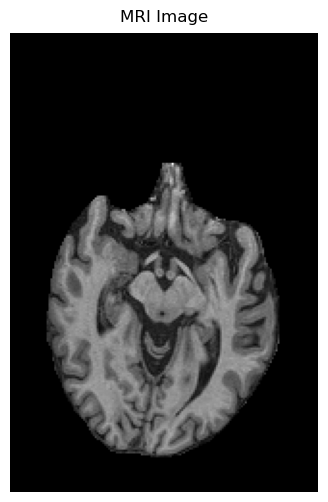

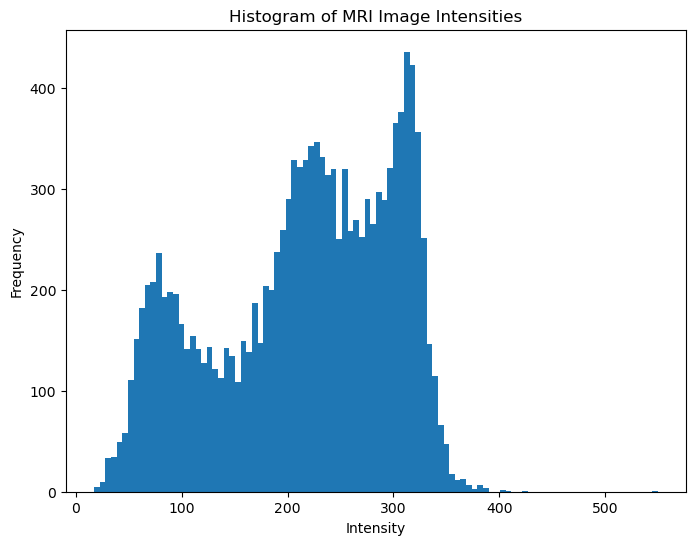

In [ ]:
# Load the data
mat = loadmat('correctedData.mat')
data = mat['correctedData']

#  image
plt.figure(figsize=(6, 6))
plt.imshow(data, cmap='gray')
plt.title('MRI Image')
plt.axis('off')
plt.show()

# histogram 
data_nonzero = data[data > 0]  
plt.figure(figsize=(8, 6))
plt.hist(data_nonzero.ravel(), bins=100)
plt.title('Histogram of MRI Image Intensities')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.show()


## Task 2: Initialize Gaussian-Mixture Model
Compute the minimum and maximum intensity in the image (non-zero pixels), and divide the
intensity range up into three equally wide intervals. Initialize the parameters of a 3-component
Gaussian mixture model by setting the means of the Gaussians to the centers of the intensity
intervals, the variances to the square of the width of the intervals, and the prior weights to $\frac{1}{3}$ each.

> ***Hint:***
> - In your intensity range, disregard the background pixels by clipping 0

In [ ]:
# Filter out zero-intensity pixels (background)
data_nonzero = data[data > 0]

# Compute minimum and maximum intensity 
min_intensity = np.min(data_nonzero)
max_intensity = np.max(data_nonzero)

# Divide the intensity range into three intervals
interval_width = (max_intensity - min_intensity) / 3
means = [min_intensity + interval_width * (i + 0.5) for i in range(3)]
variances = [interval_width ** 2] * 3
weights = [1 / 3] * 3

# Display the initialized GMM parameters
print("Initialized GMM Parameters:")
print(f"Means: {means}")
print(f"Variances: {variances}")
print(f"Weights: {weights}")

Initialized GMM Parameters:
Means: [105.84299334433933, 283.37257001236816, 460.90214668039704]
Variances: [31516.750591929533, 31516.750591929533, 31516.750591929533]
Weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


## Task 3: Display inital Gaussian distributions
Overlay the resulting Gaussian mixture model on the histogram by plotting each
Gaussian weighted by its $\pi_k$, as well as the total weighted sum of all three Gaussian distributions
(as in fig. 3.1(b) in the course notes).

> ***Hint:***
> - A gaussian distribution with the parameters $\mu$, $\sigma^2$, scaled by the weight $w$ and evaluated at positions $x$ can be obtained by the function
>        
>        w * scipy.stats.norm.pdf( x, mu, sigma).
>
> - you can use the bin edges of your histogram as $x$.

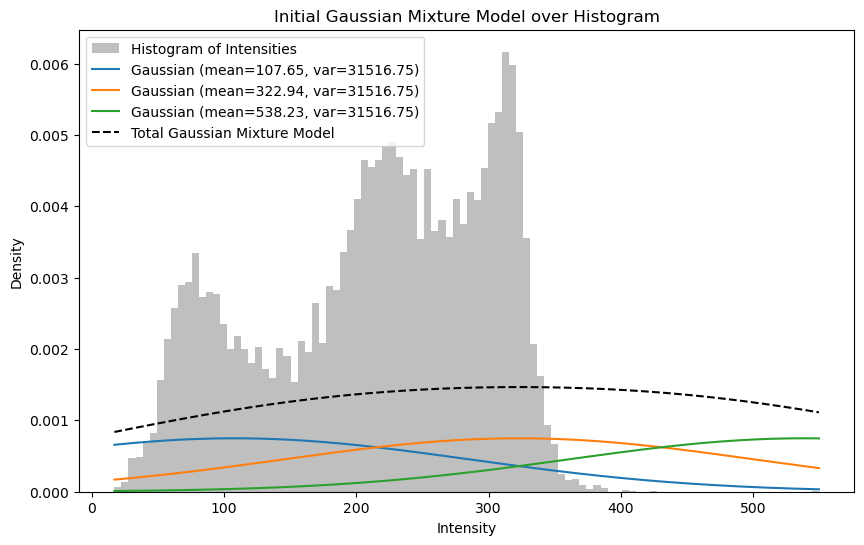

In [7]:
# Compute histogram of non-zero pixels
hist, bin_edges = np.histogram(data_nonzero, bins=100, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Initial GMM parameters from Task 2
means = [np.mean(data_nonzero) * (i + 0.5) for i in range(3)]
interval_width = (np.max(data_nonzero) - np.min(data_nonzero)) / 3
variances = [interval_width ** 2] * 3
weights = [1 / 3] * 3

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(data_nonzero, bins=100, density=True, alpha=0.5, color='gray', label='Histogram of Intensities')

# Plot each Gaussian and the total GMM
x = np.linspace(min(data_nonzero), max(data_nonzero), 1000)
total_gaussian = np.zeros_like(x)

for mean, variance, weight in zip(means, variances, weights):
    gaussian = weight * norm.pdf(x, mean, np.sqrt(variance))
    plt.plot(x, gaussian, label=f'Gaussian (mean={mean:.2f}, var={variance:.2f})')
    total_gaussian += gaussian

# Plot the total Gaussian mixture model
plt.plot(x, total_gaussian, 'k--', label='Total Gaussian Mixture Model')

plt.xlabel('Intensity')
plt.ylabel('Density')
plt.legend()
plt.title('Initial Gaussian Mixture Model over Histogram')
plt.show()


## Task 4: Compute weights
Compute the values of ${w}_{n,k}$ defined by:

$$ \mathcal{w}_{n,k} = \frac{\mathcal{N}(d_n \vert \tilde{\mu}_k, \tilde{\sigma}^2_k) \tilde{\pi}_k}{\sum^K_{k'=1} \mathcal{N}(d_n \vert \tilde{\mu}_k', \tilde{\sigma}^2_{k'}) \tilde{\pi}_k'}. $$

Visualize the values of each ${w}_{n,k}$ in a figure. You should have three plots which each display only the pixels that belong to the respective class, according to the weights.

> ***Hint:***
> - The segmentation of a pixel is determined by assigning the class of the highest probability. 
> - In your visualization, disregard the background pixels by clipping 0

## Task 5: Estimate Maximum Likelihood parameters
Estimate the maximum likelihood parameters by iterating between updating the model parameter
estimate according to 

$$ \tilde{\mu_k} \leftarrow \frac{\sum^N_{n=1} w_{n,k} d_n}{\sum^N_{n=1} w_{n,k}}  $$

$$ \tilde{\sigma}^2_k \leftarrow \frac{\sum^N_{n=1} w_{n,k} (d_n - \tilde{\mu_k})^2}{\sum^N_{n=1} w_{n,k}}  $$

$$ \tilde{\pi_k} \leftarrow \frac{\sum^N_{n=1} w_{n,k}}{N}  $$

and by recomputing ${w}_{n,k}$ according to eq. 3.33 (see Task 4).

Make sure to perform enough iterations (e.g., 100) for the algorithm to converge. As the iterations progress, plot
the evolution of the log likelihood function, and update each time the display of ${w}_{n,k}$ as well as
the Gaussian mixture model plot overlaid on the histogram. Include the evolution of the log
likelihood function and the plot of the final ${w}_{n,k}$ and the final mixture model in your report.

> ***Hint:***
> - The log likelihood can be simply computed by
>       $\log ( \sum_k w_k x_k )$

## Task 6: Vary only one model parameter
Keeping all other parameters fixed to their estimated values, vary only $\mu_2$ (the mean of the middle
Gaussian distribution) between the estimated values of $\mu_1$ and $\mu_3$ in about 100 steps, and plot for
each step the log likelihood function.

## Task 7: Locate Lower bound
On the same figure, also plot the lower bound corresponding to the parameter vector in which all
parameters are set to their estimated values, except $\mu_2$ which is set to the estimated value of $\mu_1$.

## Task 8: Maximize lower bound
Compute the value for $\mu_2$ that maximizes this lower bound (first line of eq. 3.35), indicate its location
on the figure, and comment on the result.

Formulate the lower bound as 

$$ Q(\theta \vert \tilde{\theta}) = -\frac{1}{2} \sum^K_{k=1} [\frac{1}{\sigma^2_k} \sum^N_{n=1} w_{n,k} (d_n - \mu_k - \sum^M_{m-1} c_m \phi_{n,m})^2 + (\sum^N_{n-1} w_{n,k}) \log \sigma^2_k] $$

$$ + \sum^K_{k=1} [(\sum^N_{n=1} w_{n,k}) \log \pi_k] $$

$$ - \sum^N_{n=1} \sum^K_{k=1} w_{n,k} \log w_{n,k} - \frac{N}{2} \log (2\pi) $$
